Policy (random, before training):
00,U,[-0.17 +0.21 +0.04 +0.32] 01,U,[-0.17 +0.29 -0.03 +0.33] 02,U,[-0.11 +0.16 +0.08 +0.36] 03,U,[-0.16 +0.17 +0.11 +0.33] 
04,U,[-0.10 +0.22 +0.05 +0.32] 05,U,[-0.22 +0.22 +0.02 +0.44] 06,U,[-0.18 +0.22 +0.06 +0.31] 07,U,[-0.16 +0.28 +0.01 +0.31] 
08,U,[-0.07 +0.20 -0.02 +0.32] 09,U,[-0.16 +0.28 +0.04 +0.33] 10,U,[-0.26 +0.23 +0.05 +0.43] 11,D,[-0.15 +0.29 -0.07 +0.27] 
12,U,[-0.08 +0.23 -0.02 +0.30] 13,U,[-0.13 +0.30 -0.01 +0.39] 14,U,[-0.13 +0.18 +0.06 +0.31] 15,U,[-0.16 +0.27 +0.04 +0.37] 
policy_dqn is: 
00,D,[+0.24 +0.66 +0.31 +0.30] 01,R,[+0.29 +0.32 +0.42 +0.27] 02,D,[+0.31 +0.49 +0.32 +0.33] 03,L,[+0.43 +0.14 +0.35 +0.31] 
04,D,[+0.40 +0.71 +0.19 +0.41] 05,R,[+0.28 +0.45 +0.71 +0.42] 06,D,[+0.21 +0.59 +0.38 +0.32] 07,D,[+0.29 +0.40 +0.38 +0.36] 
08,R,[+0.35 +0.25 +0.79 +0.43] 09,R,[+0.25 +0.33 +0.84 +0.44] 10,D,[+0.32 +0.85 +0.10 +0.37] 11,D,[+0.27 +0.35 +0.29 +0.28] 
12,D,[+0.37 +0.48 +0.37 +0.37] 13,R,[+0.20 +0.49 +0.62 +0.42] 14,R,[+0.33 +

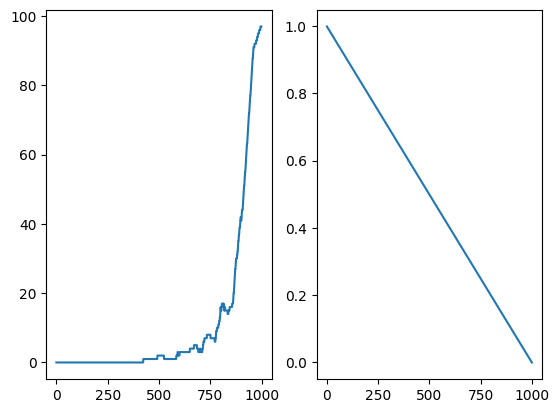

In [ ]:
!pip install gymnasium

import gymnasium as gym
import torch as torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
from collections import deque

class deepQnet(nn.Module):
                                             # when ever we define a class we need to have __init__
  def __init__(self,nInput,nHidden,nOutput):
    super().__init__()
    self.fc1=nn.Linear(nInput,nHidden)
    self.outfcn=nn.Linear(nHidden,nOutput)
  def forward(self,x):                #this calculates output for an input through the network
    x=F.relu(self.fc1(x))
    x=self.outfcn(x)
    return x
class replay_buffer_memory():
  def __init__(self,maxlen):
    self.memory=deque([],maxlen=maxlen)   # double ended queue stores the states rewards nextstates actions
  def addData(self,transition):
    self.memory.append(transition)
  def sample(self,sampSize):
    return random.sample(self.memory,sampSize)     # gives random batch of given size
  def __len__(self):
    return len(self.memory)

class lake():
  learning_rate=0.001              # alpha for the equation of Temporal difference
  disc_factor=0.9                   #gamma
  replay_mem=1000                   # memory of replay buffer
  batch_sz=32                       # buffer size each time
  sync_rate=10                      # time steps after which sync of target and policy networks sync
  loss_fn=nn.MSELoss()
  optimizer=None
  ACTIONS=['L','D','R','U']

  def __init__(self):
    self.one_hot_cache={}

  def train(self,episodes,render=False,is_slippery=False):
    env=gym.make('FrozenLake-v1',map_name="4x4",is_slippery=is_slippery,render_mode='human' if render else None)
    num_states=env.observation_space.n
    num_actions=env.action_space.n

    epsilon=1 #100% random actions
    memory=replay_buffer_memory(self.replay_mem) #creating an object of memory class for lake object

    # create a target and policy network as objects of DeepQnet class
    policy_net=deepQnet(nInput=num_states,nHidden=num_states,nOutput=num_actions)
    target_net=deepQnet(nInput=num_states,nHidden=num_states,nOutput=num_actions)
    target_net.load_state_dict(policy_net.state_dict()) ##make target and policy networks same
    print('Policy (random, before training):')
    self.print_dqn(policy_net)

    self.optimizer=torch.optim.Adam(policy_net.parameters(),lr=self.learning_rate)
    rewardsPerEpisode = np.zeros(episodes) # rewards are stored in episodes initialized to 0

    #epsilon decay has to be tracked
    epsilonHistory=[]
    step_cnt=0;
    for i in range(episodes):
      state=env.reset()[0]
      terminated=False
      truncated=False
      while((not terminated) and (not truncated) ):
        if random.random()<epsilon:
          action=env.action_space.sample()
        else:
          with torch.no_grad():
            action=policy_net(self.state_to_dqn(state,num_states)).argmax().item()  #gives current state and total states to DQN
        nxt_state,reward,terminated,truncated,_= env.step(action)
        memory.addData((state,action,nxt_state,reward,terminated))
        state=nxt_state
        step_cnt+=1
      if reward==1:
          rewardsPerEpisode[i]=1
      if(len(memory)>self.batch_sz and np.sum(rewardsPerEpisode)>0): # only if the batch size is met and rewards are received
          mini_batch=memory.sample(self.batch_sz)
          self.optim(mini_batch,policy_net,target_net) #a function
      epsilon=max(epsilon-1/episodes,0)
      epsilonHistory.append(epsilon)
      if step_cnt>self.sync_rate:
         target_net.load_state_dict(policy_net.state_dict())
         step_cnt=0
    env.close()
    torch.save(policy_net.state_dict(),"frozenLake_dict.pt")
    plt.figure(1)
    tot_sum=np.zeros(episodes)
    for i in range(episodes): #down line
      tot_sum[i]=np.sum(rewardsPerEpisode[max(0,i-100):i+1]) #recent 100 episodes cumulative sum is added
    plt.subplot(121)
    plt.plot(tot_sum)
    plt.subplot(122)
    plt.plot(epsilonHistory)
    plt.savefig("frozen_lake_graph.png")

  def optim(self, mini_batch, policy_net, target_net):
    num_states = policy_net.fc1.in_features
    current_q_list = []
    targetQlist = []

    for state, action, nxt_state, reward, terminated in mini_batch:
      if terminated:
        target = torch.FloatTensor([reward])
      else:
        with torch.no_grad():
          target = reward + self.disc_factor * target_net(self.state_to_dqn(nxt_state, num_states)).max()
      current_q = policy_net(self.state_to_dqn(state, num_states))
      current_q_list.append(current_q)
      target_q = current_q.clone()
      target_q[action] = target
      targetQlist.append(target_q)

    loss = self.loss_fn(torch.stack(current_q_list), torch.stack(targetQlist))
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def state_to_dqn(self, stt, num_stts):
    if stt not in self.one_hot_cache:
      arr = torch.zeros(num_stts)
      arr[stt] = 1
      self.one_hot_cache[stt] = arr
    return self.one_hot_cache[stt]
  def test(self, numEpisodes, is_slippery=False):
    env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=is_slippery, render_mode='human')
    numState = env.observation_space.n
    numActions = env.action_space.n
    policy_dqn = deepQnet(numState, numState, numActions)
    policy_dqn.load_state_dict(torch.load("frozenLake_dict.pt"))
    policy_dqn.eval()
    print("policy_dqn is: ")
    self.print_dqn(policy_dqn)

    for this_epsd in range(numEpisodes):
      state = env.reset()[0]
      terminated = False
      truncated = False
      while not terminated and not truncated:
        with torch.no_grad():
          action = policy_dqn(self.state_to_dqn(state, numState)).argmax().item()
        state, reward, terminated, truncated, _ = env.step(action)
    env.close()

  def print_dqn(self,dqn):
      numStates=dqn.fc1.in_features
      for s in range(numStates):
            q_values = ''
            for q in dqn(self.state_to_dqn(s, numStates)).tolist():
                q_values += "{:+.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
            q_values=q_values.rstrip()              # Remove space at the end

            # Map the best action to L D R U
            best_action = self.ACTIONS[dqn(self.state_to_dqn(s, numStates)).argmax()]

            # Print policy in the format of: state, action, q values
            # The printed layout matches the FrozenLake map.
            print(f'{s:02},{best_action},[{q_values}]', end=' ')
            if (s+1)%4==0:
                print() # Print a newline every 4 states
if __name__=='__main__':
      frozen_l=lake()
      is_slip=False
      frozen_l.train(1000,is_slippery=is_slip)
      frozen_l.test(10,is_slippery=is_slip)



